# AllLife Bank Customer Segmentation

## Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


## Key Questions

- How many different types (clusters/segments) of customers can be found from the data?
- How do these different groups of customers differ from each other?
- Do you get slightly different solutions from two different techniques? What are the differences?


## Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

 
**Data Dictionary**
 - Sl_No: Primary key of the records
 - Customer Key: Customer identification number
 - Average Credit Limit: Average credit limit of each customer for all credit cards
 - Total credit cards: Total number of credit cards possessed by the customer
 - Total visits bank: Total number of visits that customer made (yearly) personally to the bank
 - Total visits online: Total number of visits or online logins made by the customer (yearly)
 - Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Let's start coding!

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

### Loading Data

In [2]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

* The dataset has 660 rows and 7 columns 

## Data Overview

In [4]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

In [5]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

In [6]:
# dropping the serial no. column as it does not provide any information
df.drop("Sl_No", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


<IPython.core.display.Javascript object>

**Observations**

- The variables are all type *int* (integer).

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


<IPython.core.display.Javascript object>

**Observations**

- Avg_Credit_Limit for customers ranges from 3000 to 200000 with a mean of 34574.2.
- Customers have a minimum of 1 credit card and a maximum of 10
- We have customers who have made no visits to the bank and the maximum number of visits is 5 yearly.  
- We have customers who have made no visits to the online platform and customers who have logged on up to 15 times during the year.
- We have customers who have made no calls to customer service and customers calling up to 10 times in the year.
- We can observe that the Avg_Credit_Limit and Total_visits_online columns might have outliers to the right as there is a large difference between 75th percentile and maximum values.

In [9]:
# checking for missing values
df.isna().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values in our data

In [10]:
# let's check for duplicate values in the data
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

* There are no duplicate values in our data

In [11]:
# printing the number of occurrences of each unique value in each column
for column in df.columns:
    print(df[column].value_counts())
    print("-" * 50)

50706    2
37252    2
97935    2
96929    2
47437    2
        ..
58708    1
92501    1
33110    1
92503    1
75775    1
Name: Customer Key, Length: 655, dtype: int64
--------------------------------------------------
8000     35
6000     31
13000    28
9000     28
10000    26
         ..
99000     1
98000     1
55000     1
97000     1
43000     1
Name: Avg_Credit_Limit, Length: 110, dtype: int64
--------------------------------------------------
4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
8      11
9      11
Name: Total_Credit_Cards, dtype: int64
--------------------------------------------------
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
--------------------------------------------------
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
12      6
11      5
13      5
9       4
6       1
14      1
Name: Total_visits_online, dtype: int64
----------------

<IPython.core.display.Javascript object>

In [12]:
# dropping the Customer key column for our analysis
df.drop("Customer Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

# EDA

### Univariate Analysis

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

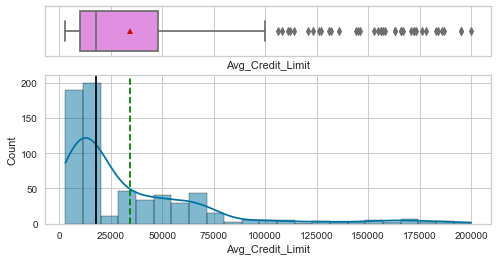

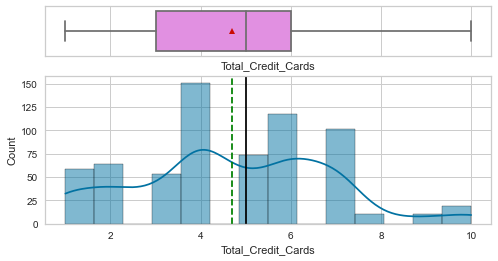

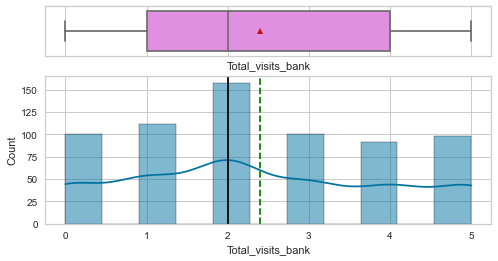

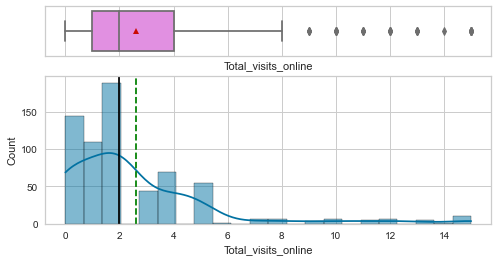

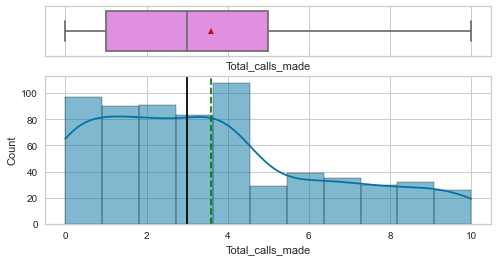

<IPython.core.display.Javascript object>

In [14]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

**Observations**

- Avg_Credit_Limit is heavily skewed to the right and as per the boxplot, there are outliers to the right.
- We will not be treating these, as some variation is always expected in real-world scenarios for this variable.
- Total_visits_online is heavily skewed to the right and as per the boxplot, there are outliers to the right.
- We will not be treating these, as these reflect a real market trend.
- Total_calls_made is skewed to the right. Majority of the customers make less than 5 calls yearly.
- Majority of the customers have made at least 2 visits to the bank.

## Outlier Treatment

In [15]:
df[df["Avg_Credit_Limit"] > 100000]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
612,157000,9,1,14,1
614,163000,8,1,7,1
615,131000,9,1,10,1
617,136000,8,0,13,0
618,121000,7,0,13,2
619,158000,7,0,13,0
620,108000,10,0,15,1
621,166000,9,1,12,2
622,176000,10,1,15,2
623,166000,10,0,7,0


<IPython.core.display.Javascript object>

In [16]:
df[df["Total_visits_online"] > 8]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,50000,3,0,10,9
4,100000,6,0,12,3
6,100000,5,0,11,2
612,157000,9,1,14,1
613,94000,9,1,11,0
615,131000,9,1,10,1
616,96000,10,1,11,2
617,136000,8,0,13,0
618,121000,7,0,13,2
619,158000,7,0,13,0


<IPython.core.display.Javascript object>

* Upon careful observation, we can confirm the outliers in these variables actually represent the real market trend.

### Bivariate Analsysis

**Let's check for correlations.**

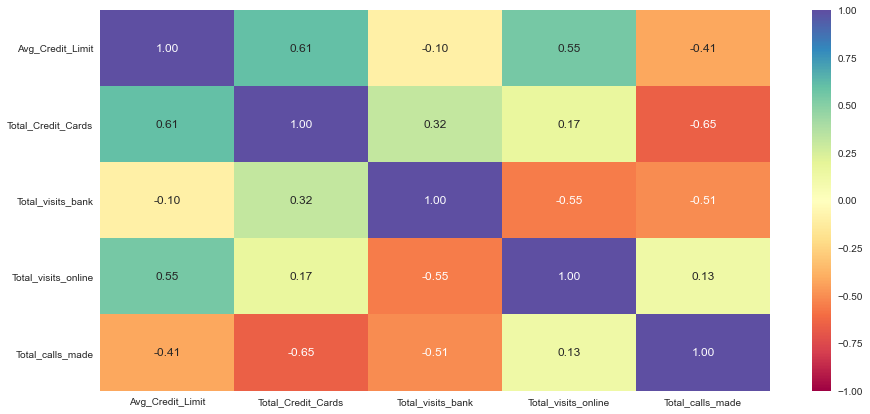

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- There is evidence to indicate some positive correlation between Avg_Credit_Limit and Total_Credit_Cards. Which could mean an increase in one variable could result in an increase in the other and vice-versa.
- This sort of correlation is also seen in a lesser extent between Avg_Credit_Limit and Total_visits_online.
- There is evidence to indicate some negative correlation between Total_calls_made and Total_Credit_Cards. Which could mean an increase in one variable could result in a decrease in the other and vice-versa.
- This sort of correlation is also seen in a lesser extent between Total_visits_bank and Total_visits_online.

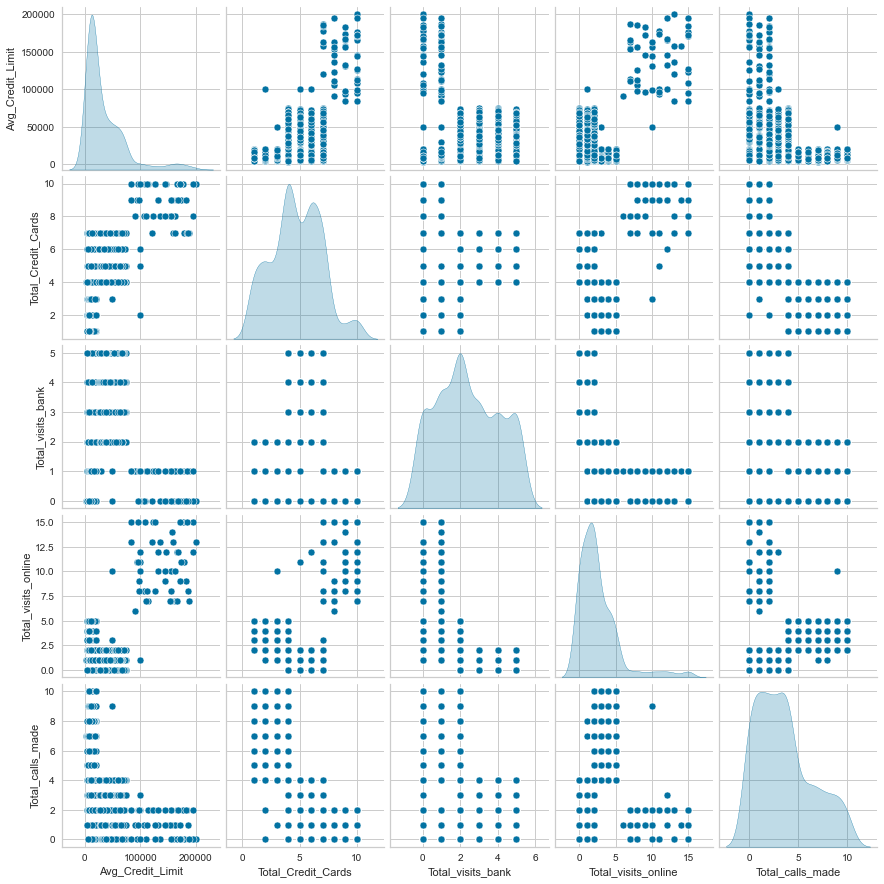

<IPython.core.display.Javascript object>

In [18]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- Total_calls_made seems to be bimodal.
- Total_Credit_Cards seems to have 4 distinct peaks.
- Total_visits_bank also has multiple peaks.
- Avg_Credit_Limit and Total_visits_online have similar distributions.

## K-means Clustering

In [19]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [20]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990906093348654
Number of Clusters: 6 	Average Distortion: 0.9431306087808111
Number of Clusters: 7 	Average Distortion: 0.9094759444859857
Number of Clusters: 8 	Average Distortion: 0.890347444362298


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

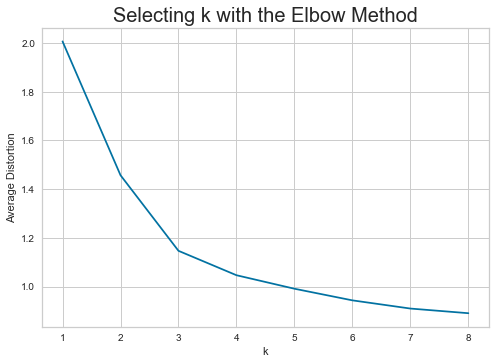

<IPython.core.display.Javascript object>

In [21]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25524450457447506
For n_clusters = 7, silhouette score is 0.24836605319652433
For n_clusters = 8, silhouette score is 0.22745995892855222
For n_clusters = 9, silhouette score is 0.22627704162595547


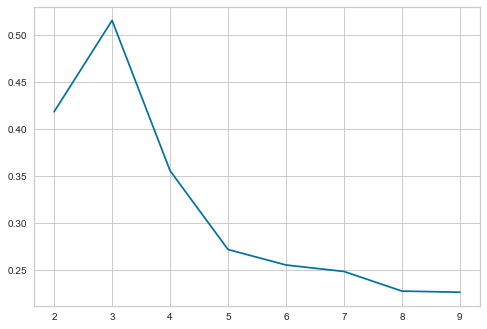

<IPython.core.display.Javascript object>

In [22]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

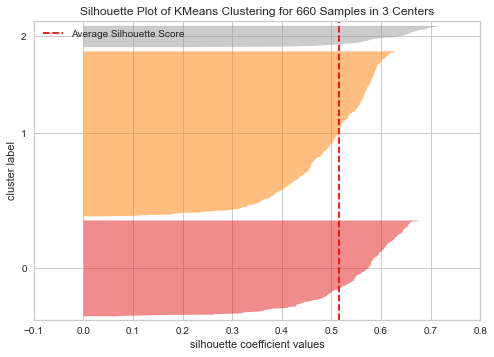

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [23]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

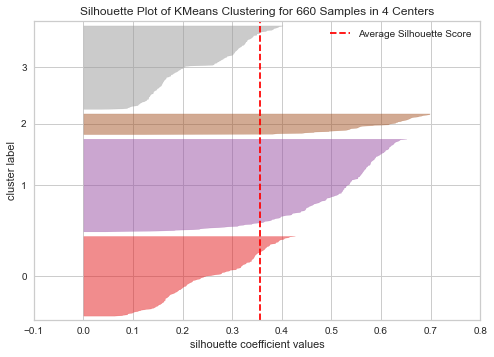

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [24]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

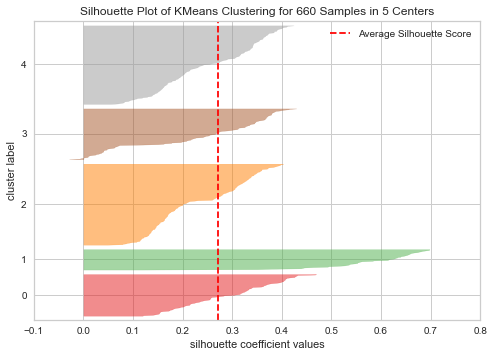

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [25]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Let's take 3 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 3 in the elbow curve.**

### K-means clustering with 3 as the number of clusters

In [26]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [27]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [28]:
cluster_profile = df.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [29]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [30]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

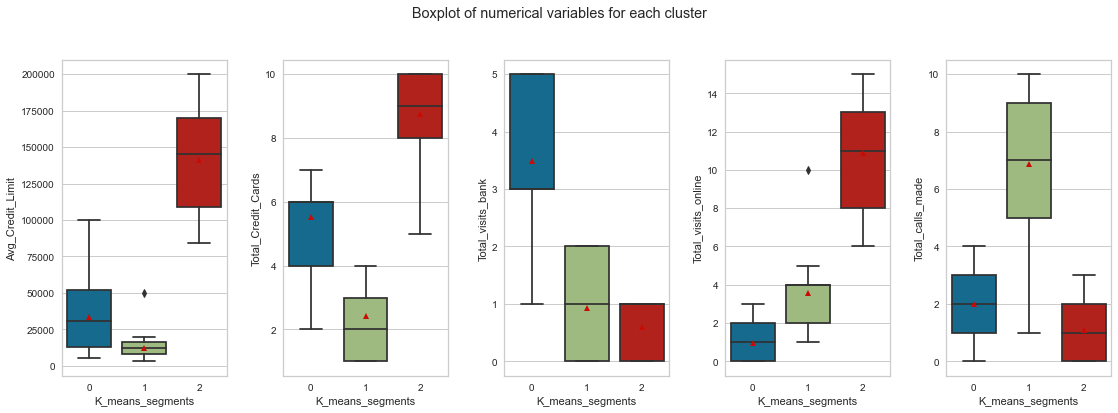

<IPython.core.display.Javascript object>

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"], showmeans=True
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights from K-means Clustering

- **Cluster 0**:
    - Average credit limit of each customer range from very low to moderate with an average of 33782.
    - Total number of credit cards possessed by the customer range from low to high with an average of 6 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from low to very high with an average of 4 visits.
    - Total number of visits or online logins made by the customer (yearly) are very low with an average of 1.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to moderate with an average of 2 calls.


- **Cluster 1**:
    - Average credit limit of each customer are very low with an average of 12174.
    - Total number of credit cards possessed by the customer range from very low to low with an average of 2 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from very low to moderate with an average of 1 visit.
    - Total number of visits or online logins made by the customer (yearly) range from very low to low with an average of 4.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to very high with an average of 7 calls.


- **Cluster 2**:
    - Average credit limit of each customer range from moderate to very high with an average of 141040.
    - Total number of credit cards possessed by the customer range from moderate to very high with an average of 9 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from very low to low with an average less than 1 visit.
    - Total number of visits or online logins made by the customer (yearly) range from moderate to very high with an average of 11.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to low with an average of 1 call.

## Hierarchical Clustering

In [32]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875361.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

<IPython.core.display.Javascript object>

In [33]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

**Let's explore different linkage methods with Euclidean distance only.**

In [34]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [35]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**We see that the cophenetic correlation is maximum with Euclidean distance and centroid linkage.**

**Let's see the dendrograms for the different linkage methods.**

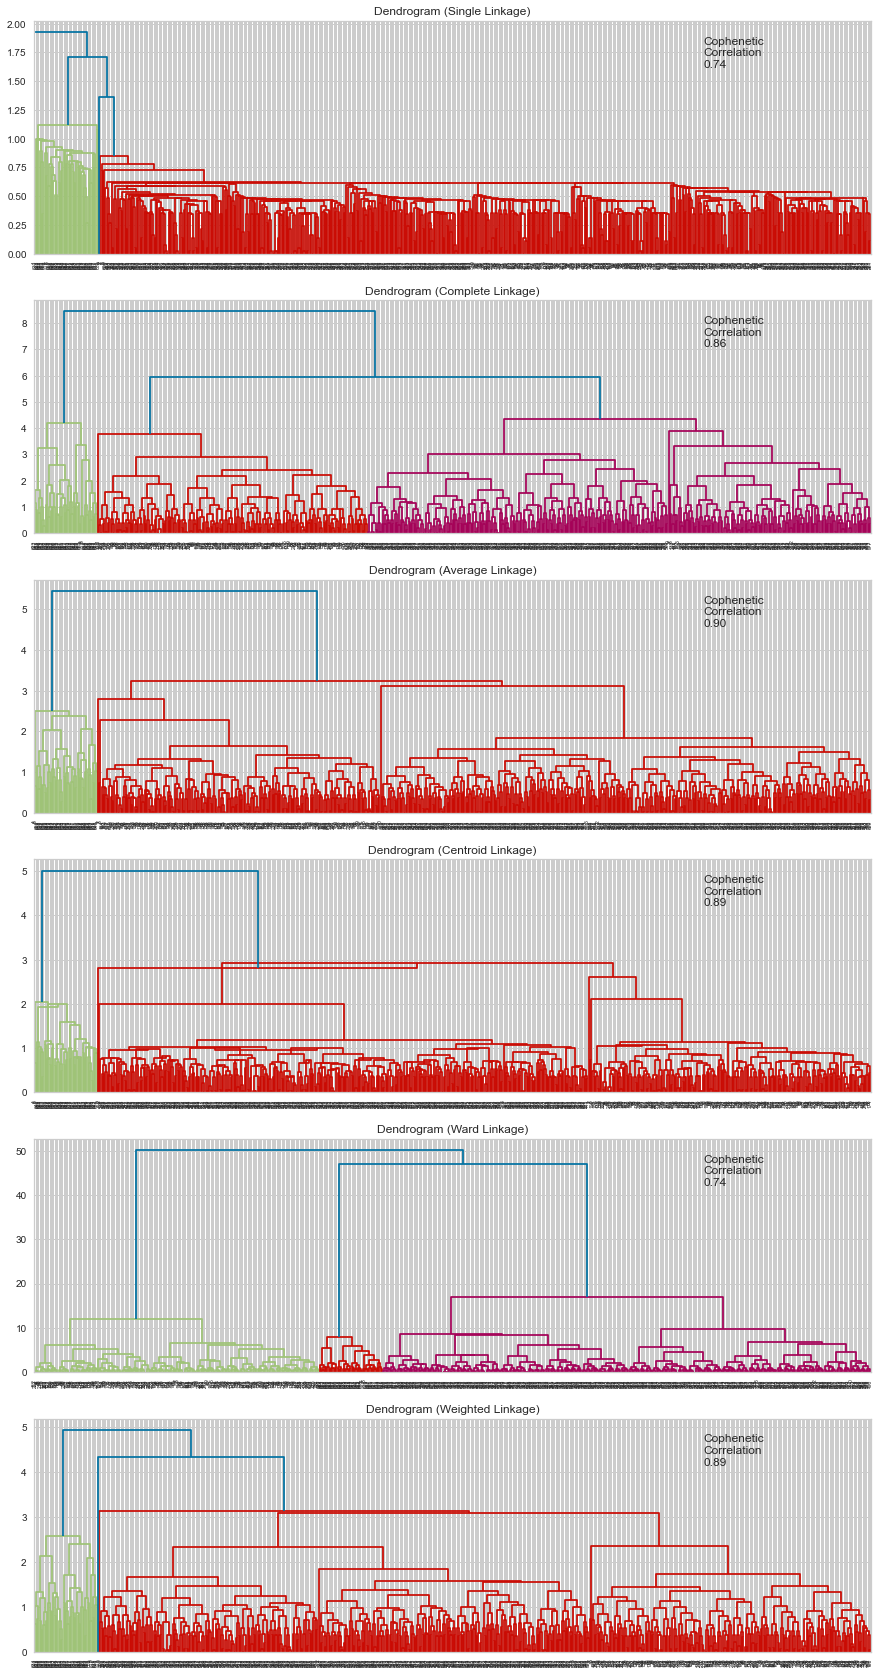

<IPython.core.display.Javascript object>

In [36]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.5703183487340514
For n_clusters = 3, silhouette score is 0.515922432650965
For n_clusters = 4, silhouette score is 0.47495143595793504
For n_clusters = 5, silhouette score is 0.44039753024783956
For n_clusters = 6, silhouette score is 0.4153547954831452
For n_clusters = 7, silhouette score is 0.4183775674672025
For n_clusters = 8, silhouette score is 0.34306710358280806
For n_clusters = 9, silhouette score is 0.3415486932890892


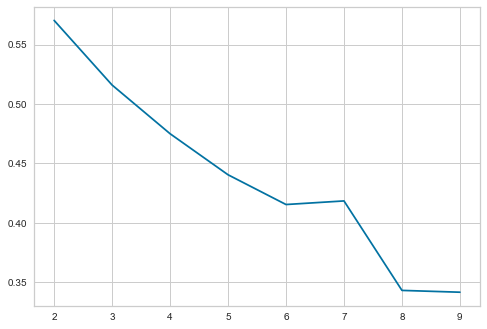

<IPython.core.display.Javascript object>

In [37]:
sil_score2 = []
cluster_list2 = list(range(2, 10))
for n_clusters in cluster_list2:
    clusterer2 = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="average"
    )
    preds2 = clusterer2.fit_predict((subset_scaled_df))
    score2 = silhouette_score(subset_scaled_df, preds2)
    sil_score2.append(score2)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score2))

plt.plot(cluster_list2, sil_score2)

**Observations**

- The cophenetic correlation is highest for average linkage followed by centroid and single linkage.
- We will move ahead with average linkage.
- 3 appears to be the appropriate number of clusters from the dendrogram for average linkage and the silhouette scores.

### Agglomerative clustering with 3 as the number of clusters

In [38]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [39]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [40]:
cluster_profile = df.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [41]:
cluster_profile["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [42]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,0.002584,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223


<IPython.core.display.Javascript object>

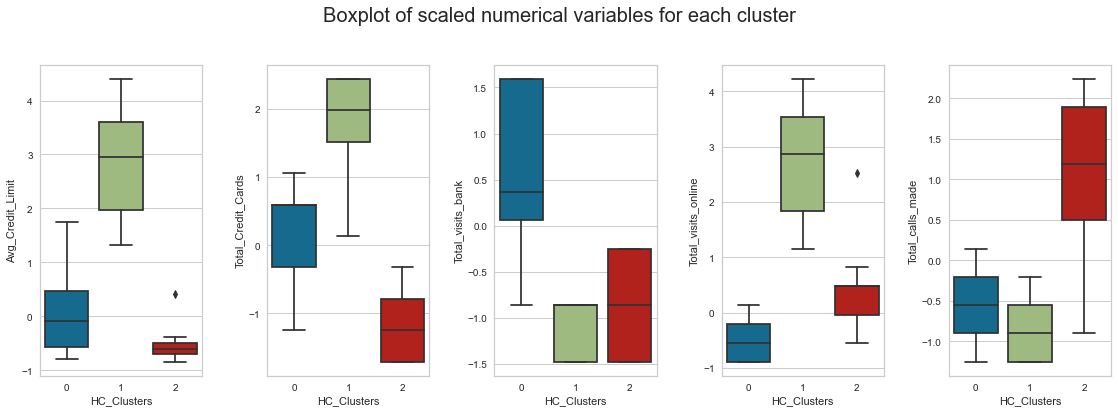

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)

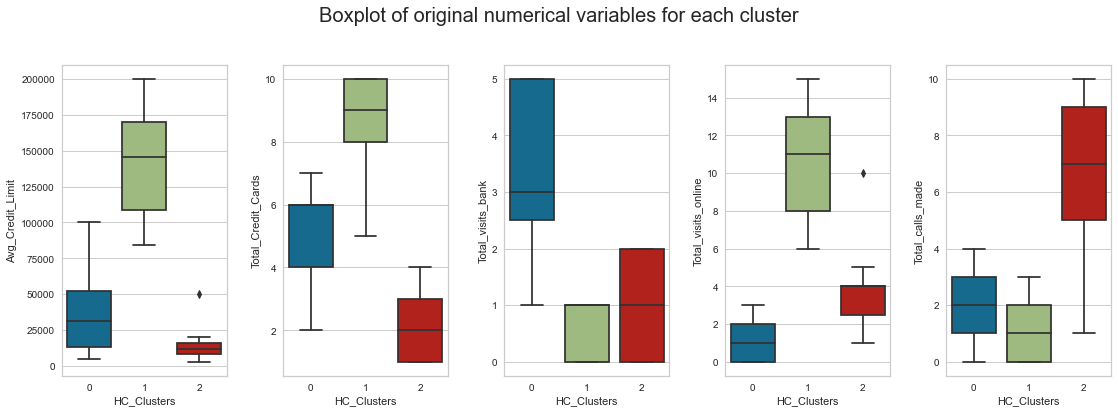

<IPython.core.display.Javascript object>

In [44]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights from Hierarchical Clustering


- **Cluster 0**:
    - Average credit limit of each customer range from very low to moderate with an average of 33782.
    - Total number of credit cards possessed by the customer range from low to high with an average of 6 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from low to very high with an average of 4 visits.
    - Total number of visits or online logins made by the customer (yearly) are very low with an average of 1.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to moderate with an average of 2 calls.


- **Cluster 1**:
    - Average credit limit of each customer range from moderate to very high with an average of 141040.
    - Total number of credit cards possessed by the customer range from moderate to very high with an average of 9 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from very low to low with an average less than 1 visit.
    - Total number of visits or online logins made by the customer (yearly) range from moderate to very high with an average of 11.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to low with an average of 1 call.
    
    
- **Cluster 2**:
    - Average credit limit of each customer are very low with an average of 12174.
    - Total number of credit cards possessed by the customer range from very low to low with an average of 2 credit cards.
    - Total number of visits that customer made (yearly) personally to the bank range from very low to moderate with an average of 1 visit.
    - Total number of visits or online logins made by the customer (yearly) range from very low to low with an average of 4.
    - Total number of calls made by the customer to the bank or its customer service department (yearly) range from very low to very high with an average of 7 calls.




### K-means Clustering vs. Hierarchical Clustering

* In hierarchical clustering we were able to use a dendogram to illustrate the arrangement of clusters from which we could select an appropriate number of clusters.
* In k-means clustering we used the elbow curve method to aid in selecting the appropriate number of clusters.
* The silhouette scores for both vary slightly with the highest score for 2 clusters in hierarchical clustering and 3 clusters in k-means clustering. 
* We selected 3 clusters as an appropriate number of clusters for both algorithms.
* During execution, the k-means technique took less time in executing than the hierarchical technique.
* We discovered the same number of observations in similar clusters for both algorithms.
* We seem to have obtained similar cluster profiles from both techniques. The key difference being cluster 2 observations in K-means clustering being classified as cluster 1 observations in hierarchical clustering and vice-versa.

### Business Recommendations

**Due to its faster execution time, we would recommend the k-means clustering technique as it will prove to be computationally less expensive, especially with larger datasets.**

The Head of Marketing and Head of Delivery should consider the following recommendations for the 3 customer clusters derived from the k-means clustering technique:

- **Cluster 2**: These are the Upper Class customers. The bank should seek to market, improve and personalize its credit card provisions and online support services to fit these customers inclination to possess a large number of credit cards and maintain communication through the bank's online channels. This should result in premium customer retention and acquisition.

- **Cluster 1**: These are the Middle Class customers. The bank should seek to market, improve and personalize its branch support services to suit these customer needs. Thereby, upselling and gaining new patronage.

- **Cluster 0**: These are the Lower Class customers. The bank should look to market, improve and personalize its call center support services to cater for these customer's reliance on call center services in contacting the bank.